In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.filterwarnings('ignore')

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Data Versioning/"
model_path = "Model/ML Model/"
data_version = "Trained_V2-3.csv"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

Mounted at /content/drive


In [2]:

df_raw = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  df_raw = df_raw.set_index('SEQN', drop=True)
  df_raw = df_raw.drop(columns = "Unnamed: 0")
except:
  pass

df_raw.head()

,Dieta1_DRDINT,Dieta1_DR1TFIBE,Quest21_SLQ300,Quest19_PAD660,Quest19_PAQ635,Dieta1_DR1TCHOL,Quest19_PAQ655,Dieta1_DR1TSFAT,Dieta1_DR1TKCAL,Exami2_BMXBMI,...,Quest1_ALQ111,Quest10_ECQ020,Quest16_MCQ220,Quest4_CBD121,Quest16_MCQ366A,Labor2_URDFLOW1,Demog1_DMDEDUC,Quest9_DLQ050,Quest20_PFQ061C,Quest16_MCQ160B
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,1,0,2,2,2.0,0,2,1,0,2,...,1.0,9.0,2.0,7.500000e+01,2.0,1.204,2.0,2.0,1.0,2.0
93708.0,1,2,2,2,2.0,0,2,1,0,0,...,2.0,9.0,2.0,5.397605e-79,2.0,0.500,1.0,2.0,2.0,2.0
93709.0,0,2,2,1,2.0,2,1,2,1,3,...,9.0,9.0,2.0,4.000000e+01,2.0,0.107,4.0,1.0,9.0,2.0
93711.0,1,3,1,0,1.0,3,3,3,3,0,...,1.0,9.0,2.0,8.570000e+02,2.0,0.605,5.0,2.0,9.0,2.0
93713.0,1,1,2,1,1.0,1,2,3,2,0,...,1.0,9.0,2.0,4.000000e+01,2.0,0.706,3.0,2.0,1.0,2.0


In [3]:
def get_categorical(df):
    categorical = []
    for col in df.columns.tolist():
        try:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': model_var[model_var['model_var_name'] ==  col]['desc'].values[0],
                    'column': col,
                    'possible_values': df[col].unique().tolist()}
                            )
        except Exception as error:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': None,
                    'column': col,
                    'possible_values': df[col].unique().tolist()})
            # print(f'{col} error: {error}')
    return categorical


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC, SMOTE

def prep_data(df):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  categorical_summary = get_categorical(X)
  categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

  # Instantiate the SMOTE oversampler
  smotenc = SMOTENC(
      categorical_features=categorical_cols,
      sampling_strategy='auto',
      random_state=37
    )

  # Apply SMOTE to generate synthetic samples
  X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

  scaler = StandardScaler()
  X_resampled.iloc[:, 28:] = scaler.fit_transform(X_resampled.iloc[:, 28:])
  X_val.iloc[:, 28:] = scaler.transform(X_val.iloc[:, 28:])

  X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
  X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

  print("Train: ", X_resampled.shape, " ", y_resampled.shape)
  print("Val: ", X_val.shape, " ", y_val.shape)
  print("Column Used: ", X.columns.tolist())

  return X_resampled, X_val, y_resampled, y_val

X_train, X_val, y_train, y_val = prep_data(df_raw)
input_shape = X_train.shape[1:]

print(y_train.value_counts())
print(y_val.value_counts())

Train:  (8050, 85, 1)   (8050,)
Val:  (1393, 85, 1)   (1393,)
Column Used:  ['Dieta1_DRDINT', 'Dieta1_DR1TFIBE', 'Quest21_SLQ300', 'Quest19_PAD660', 'Quest19_PAQ635', 'Dieta1_DR1TCHOL', 'Quest19_PAQ655', 'Dieta1_DR1TSFAT', 'Dieta1_DR1TKCAL', 'Exami2_BMXBMI', 'Dieta1_DR1TSUGR', 'Quest21_SLQ320', 'Quest21_SLQ330', 'Quest19_PAD615', 'Quest21_SLD012', 'Quest21_SLD013', 'Dieta1_DR1DAY', 'Quest6_DED120', 'Quest19_PAQ610', 'Quest6_DED125', 'Dieta1_DR1TPROT', 'Quest19_PAQ640', 'Dieta1_DR1TPFAT', 'Dieta1_DR1TMFAT', 'Dieta1_DR1TCALC', 'Dieta1_DR1TCARB', 'Dieta1_DR1TTFAT', 'Quest19_PAD645', 'Exami1_BPXPLS', 'Demog1_RIDRETH3', 'Demog1_DMDHHSZA', 'Demog1_DMDHHSZE', 'Quest14_INQ020', 'Quest18_OCQ210', 'Demog1_INDIN2', 'Quest12_HEQ030', 'Quest22_SMQ900', 'Exami2_BMXHT', 'Quest3_CDQ009', 'Quest3_CDQ010', 'Exami2_BMXWT', 'Quest3_CDQ008', 'Quest20_PFQ061H', 'Quest7_DIQ010', 'Quest20_PFQ061B', 'Labor1_LBDTCSI', 'Quest17_DPQ040', 'Demog1_RIAGENDR', 'Labor2_URDTIME1', 'Quest22_SMQ890', 'Demog1_DMDMARTL', '

In [5]:
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

def prep_data_cross_validation(df, num_folds=5):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  categorical_summary = get_categorical(X)
  categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]

  kf = KFold(n_splits=num_folds, shuffle=True, random_state=37)

  for train_index, val_index in kf.split(X):
    X_train, X_val, y_train, y_val = X.iloc[train_index, :], X.iloc[val_index, :], y.iloc[train_index], y.iloc[val_index]\

    # Instantiate the SMOTE oversampler
    smotenc = SMOTENC(
        categorical_features=categorical_cols,
        sampling_strategy='auto',
        random_state=37
      )

    # Apply SMOTE to generate synthetic samples
    X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_resampled.iloc[:, 28:] = scaler.fit_transform(X_resampled.iloc[:, 28:])
    X_val.iloc[:, 28:] = scaler.transform(X_val.iloc[:, 28:])

    X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
    X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

    yield X_resampled, X_val, y_resampled, y_val


In [6]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=()):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data
        self.logs = {}

    def on_epoch_end(self, epoch, logs={}):
        if not self.validation_data:
            raise RuntimeError("Requires validation_data.")
        if self.logs.get('roc_auc', None) == None:
          self.logs['roc_auc'] = []
        if self.logs.get('f1score', None) == None:
          self.logs['f1score'] = []

        X_val, y_val = self.validation_data
        y_proba = self.model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_proba, axis=1)

        # Convert one-hot encoded labels to class labels
        # y_pred =  [1 if preds[1] >= 2.46069816967065e-06 else 0 for preds in y_pred]

        # Compute Metrics score
        f1score = f1_score(y_val, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

        # Add Metrics score to logs
        self.logs['roc_auc'].append(roc_auc)
        self.logs['f1score'].append(f1score)

# Initial Model

In [7]:

def build_model():
  model = models.Sequential()
  model.add(layers.Input(input_shape))
  model.add(layers.Conv1D(filters=8, kernel_size=3))
  model.add(layers.Flatten())
  model.add(layers.Dense(units=4))
  model.add(layers.Dense(2, activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [8]:
tf.random.set_seed(37)
random.seed(37)

loss = []
accuracy = []
f1score = []
auc = []
train_loss = []
train_accuracy = []
train_f1score = []
train_auc = []

for X_train, X_val, y_train, y_val in prep_data_cross_validation(df_raw, num_folds=4):
  print(y_train.value_counts())
  print(y_val.value_counts())

  model = build_model()

  metrics_callback = MetricsCallback(validation_data=(X_val, y_val))
  train_metrics_callback = MetricsCallback(validation_data=(X_train, y_train))

  model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[metrics_callback, train_metrics_callback])
  _loss, _accuracy = model.evaluate(X_val, y_val, verbose=0)
  loss.append(_loss)
  accuracy.append(_accuracy)
  f1score.append(metrics_callback.logs.get('f1score'))
  auc.append(metrics_callback.logs.get('roc_auc'))

  _train_loss, _train_accuracy = model.evaluate(X_train, y_train, verbose=0)
  train_loss.append(_train_loss)
  train_accuracy.append(_train_accuracy)
  train_f1score.append(train_metrics_callback.logs.get('f1score'))
  train_auc.append(train_metrics_callback.logs.get('roc_auc'))


print()
model.summary()

Quest16_MCQ160B
0    4022
1    4022
Name: count, dtype: int64
Quest16_MCQ160B
0    1346
1      47
Name: count, dtype: int64
Epoch 1/20
252/252 [==============================] - 8s 22ms/step - loss: 0.2323 - accuracy: 0.9079 - val_loss: 0.1956 - val_accuracy: 0.9167
Epoch 2/20
252/252 [==============================] - 4s 16ms/step - loss: 0.1916 - accuracy: 0.9335 - val_loss: 0.2143 - val_accuracy: 0.9131
Epoch 3/20
252/252 [==============================] - 4s 16ms/step - loss: 0.1881 - accuracy: 0.9321 - val_loss: 0.2263 - val_accuracy: 0.9124
Epoch 4/20
252/252 [==============================] - 3s 12ms/step - loss: 0.1857 - accuracy: 0.9318 - val_loss: 0.2912 - val_accuracy: 0.8916
Epoch 5/20
252/252 [==============================] - 7s 26ms/step - loss: 0.1837 - accuracy: 0.9370 - val_loss: 0.2241 - val_accuracy: 0.9124
Epoch 6/20
252/252 [==============================] - 4s 16ms/step - loss: 0.1814 - accuracy: 0.9359 - val_loss: 0.2337 - val_accuracy: 0.9081
Epoch 7/20
252/252

In [9]:
# Evaluate Model

print(loss)
print(accuracy)
print(f1score)
print(auc)

print("Training Loss: " + str(np.mean(train_loss)*100) + "%")
print("Training Accuracy: " + str(np.mean(train_accuracy)*100) + "%")
print("Training F1 Score: " + str(np.mean(np.array(train_f1score)[:, -1])*100) + "%")
print("Training AUC: " + str(np.mean(np.array(train_auc)[:, -1])*100) + "%")

print("Loss: " + str(np.mean(loss)*100) + "%")
print("Accuracy: " + str(np.mean(accuracy)*100) + "%")
print("F1 Score: " + str(np.mean(np.array(f1score)[:, -1])*100) + "%")
print("AUC: " + str(np.mean(np.array(auc)[:, -1])*100) + "%")

[0.25734180212020874, 0.2689332365989685, 0.21680417656898499, 0.29674091935157776]
[0.8994975090026855, 0.9094827771186829, 0.9123563170433044, 0.9073275923728943]
[[0.9338895905552721, 0.9311667314186893, 0.9314457856781544, 0.9195530588769067, 0.9314457856781544, 0.9289954530099378, 0.9217778481285458, 0.9296632818736813, 0.9321026150204156, 0.924709779805838, 0.9188364809753984, 0.9227382610095767, 0.9314151018690623, 0.9292184996991464, 0.922483883469212, 0.9256707654007981, 0.9357949722987841, 0.9314457856781544, 0.9252040794151193, 0.9240708569918425], [0.9146833211985215, 0.9241963328712536, 0.9118877806962605, 0.9189863142163162, 0.9282873912170717, 0.916299531651805, 0.9174065006952163, 0.9239645763276169, 0.9199716378774249, 0.9087073687709422, 0.9189863142163162, 0.919806300553427, 0.9174065006952163, 0.9213564639865868, 0.9309252534691863, 0.9242898396328547, 0.9225762699634429, 0.9233608589501021, 0.9243172738370569, 0.9216536892843901], [0.9383052750779075, 0.92426243608

In [10]:
model = build_model()

model.summary()

X_train, X_val, y_train, y_val = prep_data(df_raw)


metrics_callback = MetricsCallback(validation_data=(X_val, y_val))
train_metrics_callback = MetricsCallback(validation_data=(X_train, y_train))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[metrics_callback, train_metrics_callback])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 83, 8)             32        
                                                                 
 flatten_4 (Flatten)         (None, 664)               0         
                                                                 
 dense_8 (Dense)             (None, 4)                 2660      
                                                                 
 dense_9 (Dense)             (None, 2)                 10        
                                                                 
Total params: 2702 (10.55 KB)
Trainable params: 2702 (10.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train:  (8050, 85, 1)   (8050,)
Val:  (1393, 85, 1)   (1393,)
Column Used:  ['Dieta1_DRDINT', 'Dieta1_DR1TFIBE', 'Quest21_SLQ300', 'Quest19_PAD660', 'Qu

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, np.argmax(model.predict(X_val), axis=1))

44/44 [==============================] - 0s 6ms/step


array([[1257,   86],
       [  32,   18]])

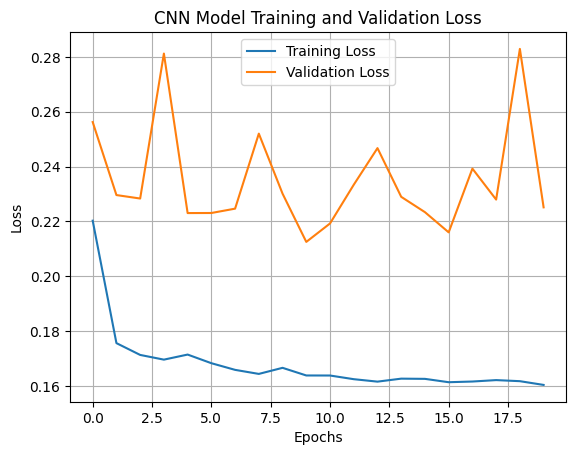

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

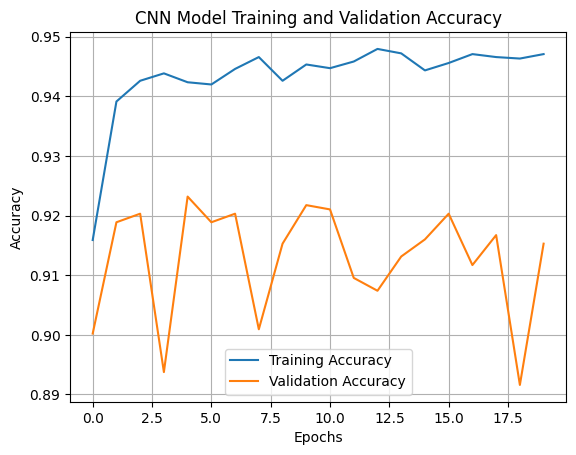

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

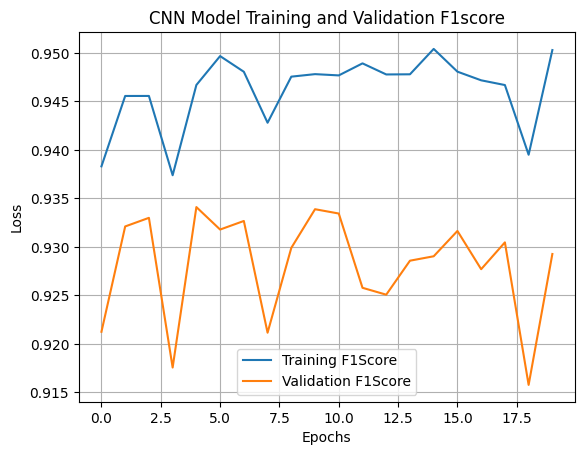

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_callback.logs.get('f1score'), label='Training F1Score')
plt.plot(metrics_callback.logs.get('f1score'), label='Validation F1Score')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Training and Validation F1score')
plt.legend()
plt.grid(True)
plt.show()

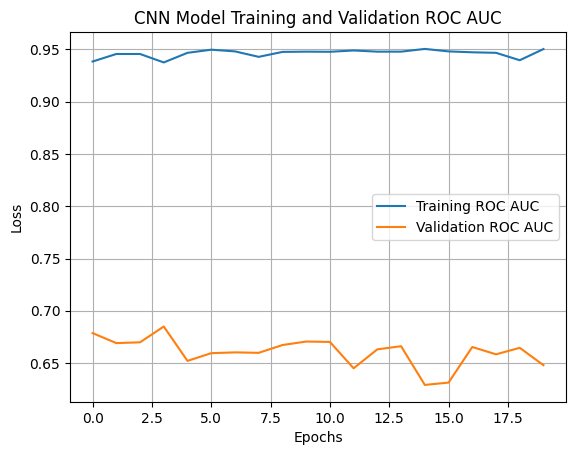

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_callback.logs.get('roc_auc'), label='Training ROC AUC')
plt.plot(metrics_callback.logs.get('roc_auc'), label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Training and Validation ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

# Find Optimum Threshold

44/44 [==============================] - 0s 3ms/step


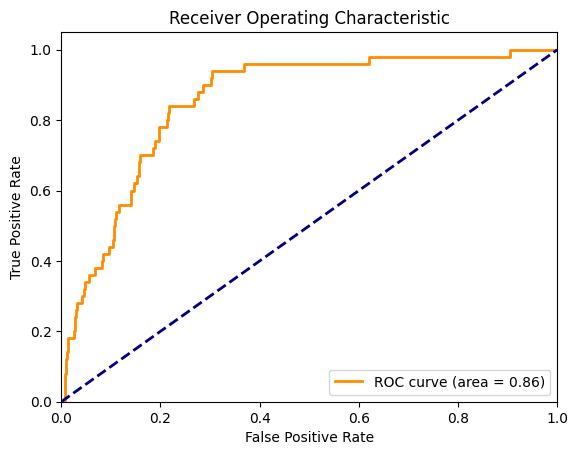

Optimal Threshold: 0.010290083475410938
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      1343
           1       0.10      0.94      0.19        50

    accuracy                           0.70      1393
   macro avg       0.55      0.82      0.50      1393
weighted avg       0.96      0.70      0.80      1393

ROC AUC Score: 0.8561429635145197


In [16]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_val)[:, 1]

# Assuming y_val are the true labels and y_pred_prob are the predicted probabilities
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

# Apply the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Evaluate performance at the optimal threshold
print(classification_report(y_val, y_pred_optimal))
print(f'ROC AUC Score: {roc_auc}')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Evaluate Model

y_proba = model.predict(X_val)
y_pred =  [1 if preds[1] >= optimal_threshold else 0 for preds in y_proba]


accuracy = accuracy_score(y_val, y_pred)
f1score = f1_score(y_val, y_pred, average='weighted')
auc = roc_auc_score(y_val, y_pred, average='weighted')

print("Accuracy: " + str(np.mean(accuracy)*100) + "%")
print("F1 Score: " + str(np.mean(f1score)*100) + "%")
print("AUC: " + str(np.mean(auc)*100) + "%")

In [18]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Evaluate Model

y_proba = model.predict(X_val)
y_pred =  [1 if preds[1] >= optimal_threshold else 0 for preds in y_proba]


accuracy = accuracy_score(y_val, y_pred)
f1score = f1_score(y_val, y_pred, average='weighted')
auc = roc_auc_score(y_val, y_pred, average='weighted')

print("Accuracy: " + str(np.mean(accuracy)*100) + "%")
print("F1 Score: " + str(np.mean(f1score)*100) + "%")
print("AUC: " + str(np.mean(auc)*100) + "%")

44/44 [==============================] - 0s 6ms/step
Accuracy: 70.42354630294328%
F1 Score: 79.6558565261347%
AUC: 81.77289650037228%


In [21]:
from sklearn.metrics import confusion_matrix


y_proba = model.predict(X_val)
y_pred = np.argmax(y_proba, axis=1)

confusion_matrix(y_val,y_pred)

44/44 [==============================] - 0s 4ms/step


array([[1248,   98],
       [  19,   28]])

In [19]:
from sklearn.metrics import confusion_matrix


y_proba = model.predict(X_val)
y_pred =  [1 if preds[1] >= optimal_threshold else 0 for preds in y_proba]

confusion_matrix(y_val,y_pred)

array([[934, 409],
       [  3,  47]])

In [24]:
from sklearn.metrics import classification_report

y_true = y_val
y_prob = model.predict(X_val)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_true, y_pred))

44/44 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1346
           1       0.22      0.60      0.32        47

    accuracy                           0.92      1393
   macro avg       0.60      0.76      0.64      1393
weighted avg       0.96      0.92      0.93      1393



In [25]:
from sklearn.metrics import classification_report

y_true = y_val
y_prob = model.predict(X_val)
y_pred = [1 if preds[1] >= optimal_threshold else 0 for preds in y_prob]

print(classification_report(y_true, y_pred))

44/44 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      1346
           1       0.09      0.96      0.17        47

    accuracy                           0.68      1393
   macro avg       0.54      0.81      0.48      1393
weighted avg       0.97      0.68      0.78      1393



# Final Model

In [7]:

def build_model_final():
  model = models.Sequential()
  model.add(layers.Input(input_shape))
  model.add(layers.Conv1D(filters=4, kernel_size=3, activation='relu'))
  model.add(layers.Conv1D(filters=32, kernel_size=2, activation='relu'))
  model.add(layers.Conv1D(filters=8, kernel_size=2, activation='relu'))
  model.add(layers.Conv1D(filters=8, kernel_size=3, activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(units=8, activation='relu'))
  model.add(layers.Dense(units=8, activation='relu'))
  model.add(layers.Dense(units=4, activation='relu'))
  model.add(layers.Dense(units=16, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [32]:
tf.random.set_seed(37)
random.seed(37)

loss = []
accuracy = []
f1score = []
auc = []
train_loss = []
train_accuracy = []
train_f1score = []
train_auc = []

for X_train, X_val, y_train, y_val in prep_data_cross_validation(df_raw, num_folds=4):
  print(y_train.value_counts())
  print(y_val.value_counts())

  model_final = build_model_final()

  metrics_callback = MetricsCallback(validation_data=(X_val, y_val))
  train_metrics_callback = MetricsCallback(validation_data=(X_train, y_train))

  model_final.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[metrics_callback, train_metrics_callback])
  _loss, _accuracy = model_final.evaluate(X_val, y_val, verbose=0)
  loss.append(_loss)
  accuracy.append(_accuracy)
  f1score.append(metrics_callback.logs.get('f1score'))
  auc.append(metrics_callback.logs.get('roc_auc'))

  _train_loss, _train_accuracy = model_final.evaluate(X_train, y_train, verbose=0)
  train_loss.append(_train_loss)
  train_accuracy.append(_train_accuracy)
  train_f1score.append(train_metrics_callback.logs.get('f1score'))
  train_auc.append(train_metrics_callback.logs.get('roc_auc'))


print()
model_final.summary()

Quest16_MCQ160B
0    4022
1    4022
Name: count, dtype: int64
Quest16_MCQ160B
0    1346
1      47
Name: count, dtype: int64
Epoch 1/20
252/252 [==============================] - 6s 14ms/step - loss: 0.3216 - accuracy: 0.8749 - val_loss: 0.1958 - val_accuracy: 0.9182
Epoch 2/20
252/252 [==============================] - 3s 10ms/step - loss: 0.1674 - accuracy: 0.9437 - val_loss: 0.1926 - val_accuracy: 0.9239
Epoch 3/20
252/252 [==============================] - 2s 10ms/step - loss: 0.1438 - accuracy: 0.9528 - val_loss: 0.1947 - val_accuracy: 0.9232
Epoch 4/20
252/252 [==============================] - 3s 10ms/step - loss: 0.1286 - accuracy: 0.9579 - val_loss: 0.2014 - val_accuracy: 0.9167
Epoch 5/20
252/252 [==============================] - 4s 18ms/step - loss: 0.1181 - accuracy: 0.9602 - val_loss: 0.2015 - val_accuracy: 0.9232
Epoch 6/20
252/252 [==============================] - 4s 17ms/step - loss: 0.1030 - accuracy: 0.9663 - val_loss: 0.1843 - val_accuracy: 0.9325
Epoch 7/20
252/252

In [33]:
# Evaluate Model

print(loss)
print(accuracy)
print(f1score)
print(auc)

print("Training Loss: " + str(np.mean(train_loss)*100) + "%")
print("Training Accuracy: " + str(np.mean(train_accuracy)*100) + "%")
print("Training F1 Score: " + str(np.mean(np.array(train_f1score)[:, -1])*100) + "%")
print("Training AUC: " + str(np.mean(np.array(train_auc)[:, -1])*100) + "%")

print("Loss: " + str(np.mean(loss)*100) + "%")
print("Accuracy: " + str(np.mean(accuracy)*100) + "%")
print("F1 Score: " + str(np.mean(np.array(f1score)[:, -1])*100) + "%")
print("AUC: " + str(np.mean(np.array(auc)[:, -1])*100) + "%")

[0.190689817070961, 0.32704636454582214, 0.1495821177959442, 0.2890468239784241]
[0.9540559649467468, 0.9303160905838013, 0.9568965435028076, 0.9389367699623108]
[[0.9345351968142485, 0.937861553454717, 0.9356355366314356, 0.9325780257802952, 0.9359541349531122, 0.9417497175408813, 0.9290651467847574, 0.922590383923804, 0.9367922466932967, 0.9405103498289852, 0.942520893135476, 0.9407444586191329, 0.951521427099224, 0.946567081401439, 0.9439037830817354, 0.9438936989768828, 0.9426525251705369, 0.9507368902334802, 0.9456704633014261, 0.9514062505258306], [0.9147003394015207, 0.9298071608945416, 0.9236370590433443, 0.9387078662459317, 0.9301038305726743, 0.9406717102714165, 0.934381362686821, 0.9330655192805726, 0.9338788326784332, 0.9316881366840639, 0.9269318055253636, 0.931560225111746, 0.9324256202098273, 0.9354158019148613, 0.9377509006690684, 0.9330655192805726, 0.9350553748084295, 0.9343506151362835, 0.9347562436615159, 0.9310746001793013], [0.9141992352020963, 0.9505769576149425,

In [8]:
model_final = build_model_final()

model_final.summary()

X_train, X_val, y_train, y_val = prep_data(df_raw)

metrics_callback = MetricsCallback(validation_data=(X_val, y_val))
train_metrics_callback = MetricsCallback(validation_data=(X_train, y_train))

history = model_final.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[metrics_callback, train_metrics_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 83, 4)             16        
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 32)            288       
                                                                 
 conv1d_2 (Conv1D)           (None, 81, 8)             520       
                                                                 
 conv1d_3 (Conv1D)           (None, 79, 8)             200       
                                                                 
 flatten (Flatten)           (None, 632)               0         
                                                                 
 dense (Dense)               (None, 8)                 5064      
                                                                 
 dense_1 (Dense)             (None, 8)                 7

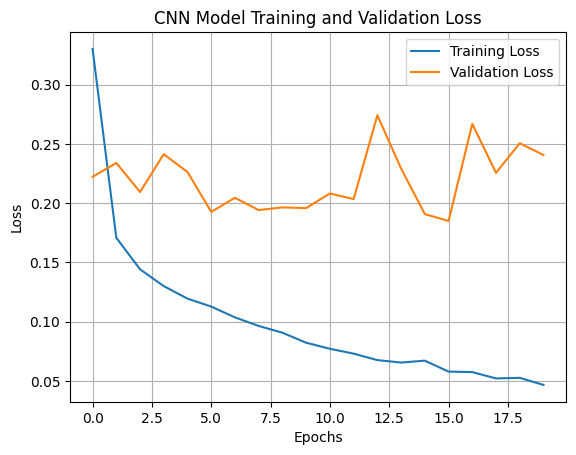

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

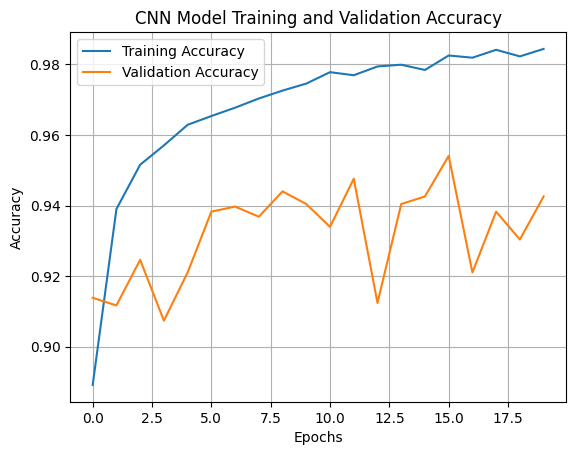

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

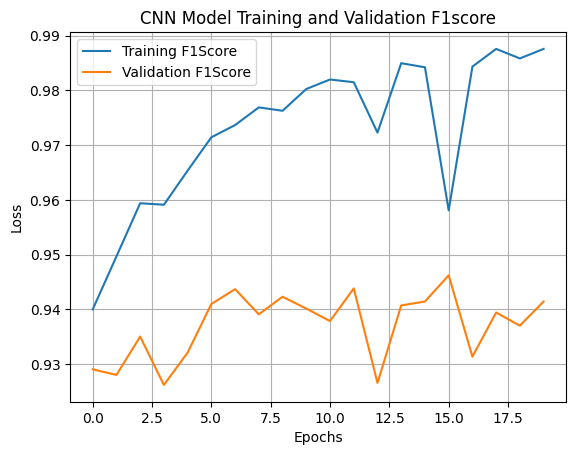

In [37]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_callback.logs.get('f1score'), label='Training F1Score')
plt.plot(metrics_callback.logs.get('f1score'), label='Validation F1Score')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Training and Validation F1score')
plt.legend()
plt.grid(True)
plt.show()

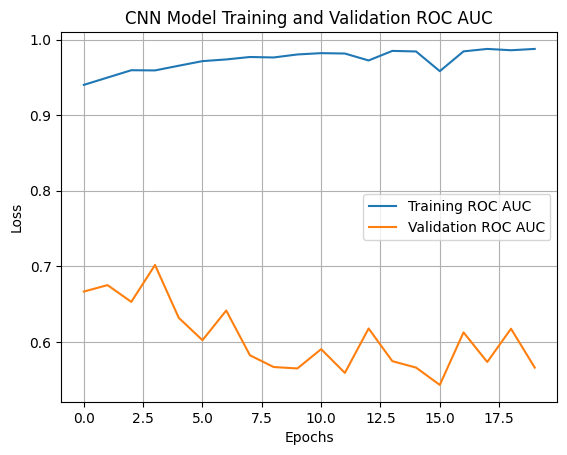

In [38]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_callback.logs.get('roc_auc'), label='Training ROC AUC')
plt.plot(metrics_callback.logs.get('roc_auc'), label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Training and Validation ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

44/44 [==============================] - 0s 2ms/step


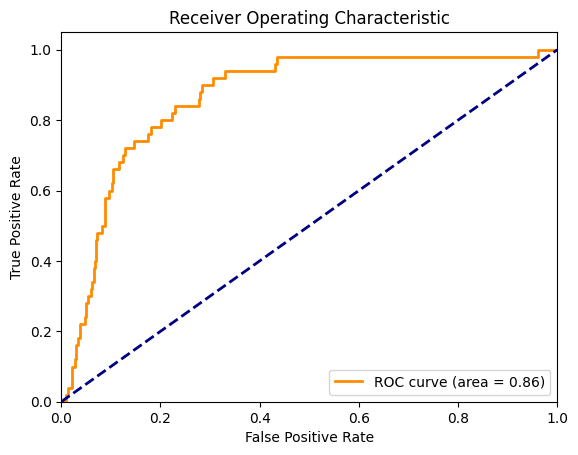

Optimal Threshold: 0.013398534618318081
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1343
           1       0.11      0.90      0.19        50

    accuracy                           0.72      1393
   macro avg       0.55      0.81      0.51      1393
weighted avg       0.96      0.72      0.81      1393

ROC AUC Score: 0.8648399106478034


In [11]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

y_pred_prob = model_final.predict(X_val)[:, 1]

# Assuming y_val are the true labels and y_pred_prob are the predicted probabilities
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

# Apply the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Evaluate performance at the optimal threshold
print(classification_report(y_val, y_pred_optimal))
print(f'ROC AUC Score: {roc_auc}')

In [9]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Evaluate Model

y_proba = model_final.predict(X_val)
y_pred =  np.argmax(y_proba, axis=1)


accuracy = accuracy_score(y_val, y_pred)
f1score = f1_score(y_val, y_pred, average='weighted')
auc = roc_auc_score(y_val, y_pred, average='weighted')

print("Accuracy: " + str(np.mean(accuracy)*100) + "%")
print("F1 Score: " + str(np.mean(f1score)*100) + "%")
print("AUC: " + str(np.mean(auc)*100) + "%")

44/44 [==============================] - 0s 4ms/step
Accuracy: 93.82627422828428%
F1 Score: 93.88450075564528%
AUC: 56.36187639612806%


In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Evaluate Model

y_proba = model_final.predict(X_val)
y_pred =  [1 if preds[1] >= optimal_threshold else 0 for preds in y_proba]


accuracy = accuracy_score(y_val, y_pred)
f1score = f1_score(y_val, y_pred, average='weighted')
auc = roc_auc_score(y_val, y_pred, average='weighted')

print("Accuracy: " + str(np.mean(accuracy)*100) + "%")
print("F1 Score: " + str(np.mean(f1score)*100) + "%")
print("AUC: " + str(np.mean(auc)*100) + "%")

44/44 [==============================] - 0s 2ms/step
Accuracy: 72.21823402727925%
F1 Score: 80.92896017761035%
AUC: 80.77810871183915%


In [15]:
from sklearn.metrics import confusion_matrix


y_proba = model_final.predict(X_val)
y_pred = np.argmax(y_proba, axis=1)

confusion_matrix(y_val,y_pred)

44/44 [==============================] - 1s 11ms/step


array([[1299,   44],
       [  42,    8]])

In [16]:
from sklearn.metrics import confusion_matrix


y_proba = model_final.predict(X_val)
y_pred =  [1 if preds[1] >= optimal_threshold else 0 for preds in y_proba]

confusion_matrix(y_val,y_pred)

44/44 [==============================] - 0s 8ms/step


array([[961, 382],
       [  5,  45]])

44/44 [==============================] - 0s 5ms/step


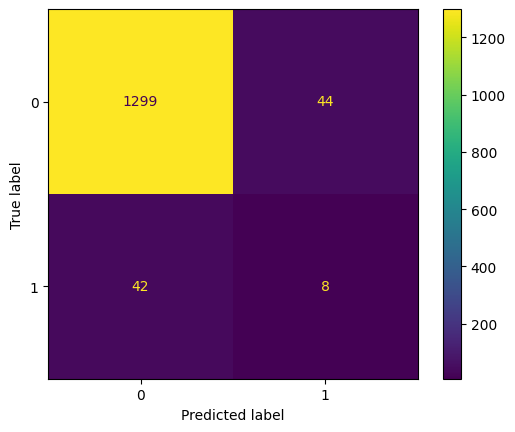

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_proba = model_final.predict(X_val)
y_pred = np.argmax(y_proba, axis=1)

cm = confusion_matrix(y_val,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

44/44 [==============================] - 0s 4ms/step


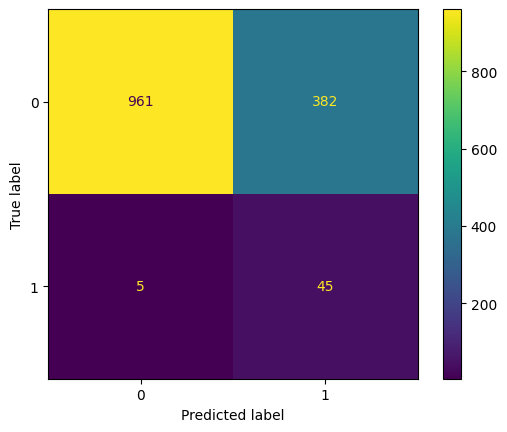

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_proba = model_final.predict(X_val)
y_pred =  [1 if preds[1] >= optimal_threshold else 0 for preds in y_proba]

cm = confusion_matrix(y_val,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

In [24]:
cm

array([[961, 382],
       [  5,  45]])

In [46]:
from sklearn.metrics import classification_report

y_true = y_val
y_prob = model_final.predict(X_val)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_true, y_pred))

44/44 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1343
           1       0.17      0.16      0.17        50

    accuracy                           0.94      1393
   macro avg       0.57      0.57      0.57      1393
weighted avg       0.94      0.94      0.94      1393



In [47]:
from sklearn.metrics import classification_report

y_true = y_val
y_prob = model_final.predict(X_val)
y_pred = [1 if preds[1] >= optimal_threshold else 0 for preds in y_prob]

print(classification_report(y_true, y_pred))

44/44 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1343
           1       0.09      0.80      0.17        50

    accuracy                           0.72      1393
   macro avg       0.54      0.76      0.50      1393
weighted avg       0.96      0.72      0.80      1393

